update direction of optimization for intertia also in previous blogs!

In [1]:
from __future__ import division # python2 
import math
import numpy as np
from scipy.optimize import brentq

def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    
    rule = w1*(abs(xt-c1/r1))**3+(1-w1)*(abs(xt-c2/r2))**3
    at = min(max(rule, 0.01), 0.1)
    return at

def lake_model(b=0.42, q=2.0, mean=0.02, stdev=0.001, alpha=0.4,     
                 delta=0.98, c1=0.25, c2=0.25, r1=0.5, r2=0.5,
                 w1=0.5, nsamples=100, steps=100, seed=None):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    np.random.seed(seed)
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    X = np.zeros((steps,))
    decisions = np.zeros((steps,))

    X[0] = 0.0

    natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=steps)

    for t in range(steps-1):
        decisions[t] = get_antropogenic_release(X[t], c1, c2, r1, r2, w1)
        X[t+1] = (1-b)*X[t] + X[t]**q/(1+X[t]**q) + decisions[t] + natural_inflows[t]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    
    # note that I have slightly changed this formulation to retain
    # consistency with the equations in the papers
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

from ema_workbench import (RealParameter, ScalarOutcome, Constant, 
                           ReplicatorModel)

model = ReplicatorModel('lakeproblem', function=lake_model)
model.replications = 150

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2), 
                RealParameter("r2", 0, 2), 
                RealParameter("w1", 0, 1)]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                function=process_p),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                function=np.mean),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                function=np.mean),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                function=np.mean)]

# override some of the defaults of the model
model.constants = [Constant('alpha', 0.41),
                   Constant('steps', 100)]

# Directed search with the Exploratory Modeling workbench

This is the third blog in a series showcasing the functionality of the Exploratory Modeling workbench.  Exploratory modeling entails investigating the way in which uncertainty and/or policy levers map to outcomes. To investigate these mappings, we can either use sampling based strategies (open exploration) or optimization based strategies (directed search) In the [first blog](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/), I gave a general overview of the workbench and showed briefly how both investigation strategies can be done. In the [second blog](), I demonstrated the use of the workbench for open exploration in substantial more detail. In this third blog, I will demonstrate in more detail how to use the workbench for directed search. Like in the previous two blog post, I will use the DPS version of the lake problem.  

platypus

```terminal
git pip install trick
```

* Search over levers
* Search over uncertainties: worst case discovery
* Robust search

specification of direction for outcomes (minimize, maximize, info), only possible to optimize over scalar outcomes.


## Search over levers
Directed search is most often used to search over the decision levers in order to find good candidate strategies. This is for example the first step in the [Many Objective Robust Decision Making process](). This is straightforward to do with the workbench using the optimize method.


In [4]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=100, searchover='levers', 
                                 epsilons=[0.1,]*len(model.outcomes),
                                 population_size=50)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 50 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 34 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 50 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 34 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


the results from optimize is a DataFrame with the decision variables and outcomes of interest. 

In [5]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-1.895108,-1.283488,1.454377,1.809301,0.539255,2.283667,1.772582,0.989899,0.07
1,0.149778,1.128526,1.797692,1.762793,0.651230,0.228591,0.527601,0.976835,1.00
2,-0.183842,0.461778,0.765907,1.325156,0.894940,2.283776,1.592274,0.959596,0.12
3,-0.164814,0.572304,1.464873,1.762059,0.274790,0.096258,0.209388,0.989899,1.00


### Specifying constraints
It is possible to specify a constrained optimization problem. A model can have one or more constraints. A constraint can be applied to the model input parameters (both uncertainties and levers), and/or outcomes. A constraint is essentially a function that should return the distance from the feasibility threshold. The distance should be 0 if the constraint is met.


In [6]:
from ema_workbench import Constraint

model.constraints = [Constraint("max pollution", outcome_names="max_P",
                      function=lambda x:max(0, x-1))]

In [7]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=100, searchover='levers', 
                                 epsilons=[0.1,]*len(model.outcomes),
                                 population_size=25)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 25 policies * 1 model(s) = 25 experiments
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 26 policies * 1 model(s) = 26 experiments
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 26 policies * 1 model(s) = 26 experiments
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 26 policies * 1 model(s) = 26 experiments
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [8]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.268200,0.356875,0.798697,0.702906,0.002402,0.212782,0.520996,0.969697,1.0
1,0.028828,1.052911,0.596582,1.722438,0.691783,0.190484,0.483638,0.979798,1.0
2,0.030561,0.631439,1.386814,1.700615,0.438591,0.098296,0.220050,0.986936,1.0


### tracking convergence 

```python
with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_results = evaluator.optimize(searchover='levers', 
                      nfe=10000, convergence=['hypervolume', 'e-progress'] 
                      epsilons=[0.1,]*len(model.outcomes))
```

basically, convergence takes one of more strings with the kind of progress you want to track. The list should match the various progress metrics available in platypus, might also just take a boolean (but what would be the default)

implementation would involve a general callback class to which you add functions for each progress indicator. __call__ can then loop over these functions



In [14]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[1,1,1,1]),
                       xEpsilonProgress()]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=500, searchover='levers', 
                                    epsilons=[0.1,]*len(model.outcomes),
                                    convergence=convergence_metrics,
                                    population_size=50)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 50 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 34 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 48 policies * 1 model(s) = 48 experiments
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 48 policies * 1 model(s) = 48 experiments
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 50 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 34 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 49 policies * 1 model(s) = 49 experiment

In [15]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.453774,0.545421,1.403000,1.481169,0.933565,0.099130,0.226716,0.979798,1.0
1,0.683412,0.060178,1.281227,1.480484,0.631371,0.197515,0.501344,0.979731,1.0


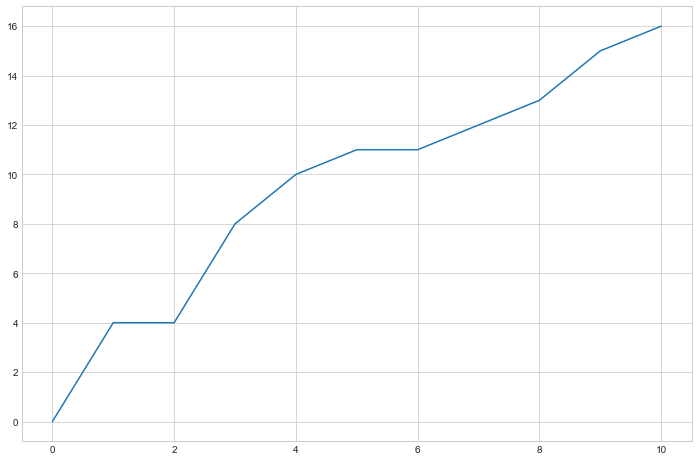

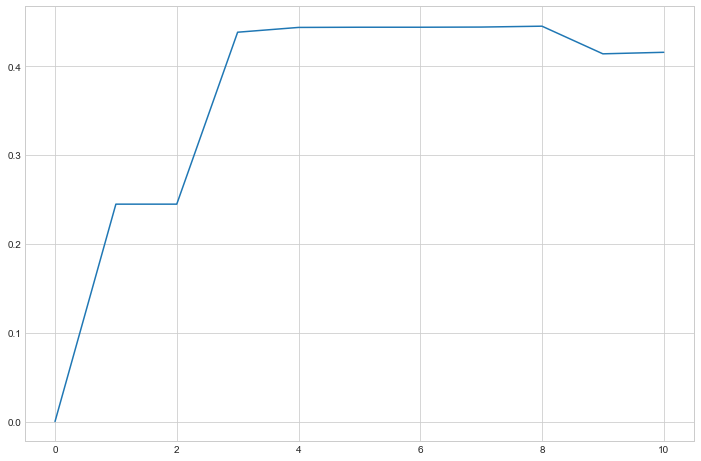

In [18]:
fig, ax = plt.subplots()
ax.plot(convergence.epsilon_progress)
plt.show()

fig, ax = plt.subplots()
ax.plot(convergence.hypervolume)
plt.show()

### Changing the reference scenario 



## Search over uncertainties: worst case discovery

In [ ]:
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=1000, searchover='uncertainties', 
                                 epsilons=[0.1,]*len(model.outcomes))

## Robust Search

In [ ]:
import functools

percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
robustnes_functions = [ScalarOutcome('90th percentile max_p', kind=MINIMIZE, 
                             variable_name='max_P', function=percentile90),
                       ScalarOutcome('10th percentile reliability', kind=MAXIMIZE, 
                             variable_name='reliability', function=percentile10),
                       ScalarOutcome('10th percentile inertia', kind=MAXIMIZE, 
                             variable_name='inertia', function=percentile10),
                       ScalarOutcome('10th percentile utility', kind=MAXIMIZE, 
                             variable_name='utility', function=percentile10)]

n_scenarios = 200
scenarios = sample_uncertainties(lake_model, n_scenarios)
nfe = 100000

with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results = evaluator.robust_optimize(robustnes_functions, scenarios, 
                            nfe=nfe, epsilons=[0.05,]*len(robustnes_functions))